Plot for complete markets

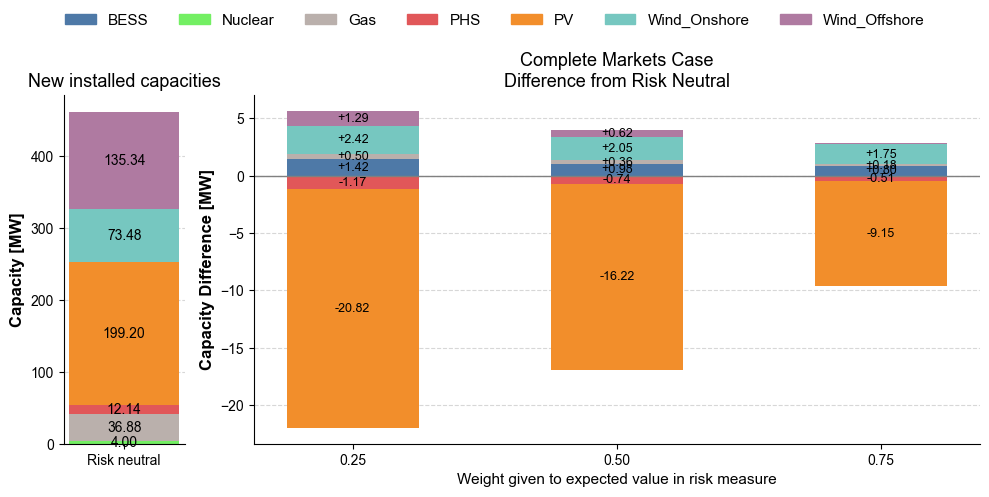

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# === Global font setup ===
rcParams['font.family'] = 'Arial'
rcParams['axes.labelweight'] = 'bold'

# === Load data ===
df_raw = pd.read_csv(r"C:\Users\user\Desktop\msc-thesis-incomplete-markets-LDES\models\Complete_markets_risk_averse_central_planner\cinvestorage_expensive_results\risk_aversion_results_O30_T672_new_final_unserved_fix_flex_withoutgasprice_cinvEldesexpensive_constraintswi.csv")
df = df_raw[df_raw["delta"] != 0]

# === Filter relevant columns ===
capacity_cols = ['PV', 'Gas', 'Wind_Onshore', 'Wind_Offshore', 'Nuclear', 'BESS_P', 'LDES_PHS_P']
df = df[['delta'] + capacity_cols]

# === Split data ===
df_rn = df[df['delta'] == 1].iloc[0]
df_others = df[df['delta'] != 1].sort_values('delta')

# === Define techs, labels, and colors ===
techs = ['BESS_P', 'Nuclear',  'Gas', 'LDES_PHS_P', 'PV', 'Wind_Onshore', 'Wind_Offshore']
labels = ['BESS', 'Nuclear',  'Gas', 'PHS', 'PV', 'Wind_Onshore', 'Wind_Offshore']
#techs = ['BESS_P', 'LDES_PHS_P']
#labels = ['BESS', 'PHS']
colors = {
    'BESS_P': '#4e79a7',       # Blue
    'Wind_Offshore': '#af7aa1',          # Violet
    'Nuclear': "#73ef63",      # Gray
    'LDES_PHS_P': '#e15759',   # Red
    'PV': '#f28e2b',           # Orange
    'Wind_Onshore': '#76c7c0',         # Teal
    'Gas': "#bab0ac"
}

# === Plot setup ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 6]})

for ax in [ax1, ax2]:
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)

# === Left: Risk Neutral ===
bar_width = 0.3
bottom = 0
for tech in techs:
    value = df_rn[tech]
    ax1.bar(0, value, width=bar_width, bottom=bottom, color=colors[tech])
    if value > 0.1:
        ax1.text(0, bottom + value / 2, f'{value:.2f}', ha='center', va='center', color='black', fontsize=10)
    bottom += value
ax1.set_xticks([0])
ax1.set_xticklabels(['Risk neutral'], fontsize=10)
ax1.set_ylabel("Capacity [MW]", fontsize=12, fontweight='bold')
ax1.set_title("New installed capacities", fontsize=13, fontweight='normal')
ax1.tick_params(labelsize=10)

# === Right: Differences ===
deltas = df_others['delta'].unique()
x = np.arange(len(deltas))
width = 0.5

bottom_pos = np.zeros_like(x, dtype=float)
bottom_neg = np.zeros_like(x, dtype=float)

for tech in techs:
    diffs = df_others[tech].values - df_rn[tech]
    for i, diff in enumerate(diffs):
        if diff >= 0:
            ax2.bar(x[i], diff, width=width, bottom=bottom_pos[i], color=colors[tech])
            if abs(diff) > 0.1:
                ax2.text(x[i], bottom_pos[i] + diff / 2, f'+{diff:.2f}', ha='center', va='center', fontsize=9)
            bottom_pos[i] += diff
        else:
            ax2.bar(x[i], diff, width=width, bottom=bottom_neg[i], color=colors[tech])
            if abs(diff) > 0.1:
                ax2.text(x[i], bottom_neg[i] + diff / 2, f'{diff:.2f}', ha='center', va='center', fontsize=9)
            bottom_neg[i] += diff

ax2.set_xticks(x)
ax2.set_xticklabels([f"{d:.2f}" for d in deltas], fontsize=10)
ax2.set_xlabel("Weight given to expected value in risk measure", fontsize=11, fontweight='normal')
ax2.set_ylabel("Capacity Difference [MW]", fontsize=12, fontweight='bold')
ax2.set_title("Complete Markets Case\nDifference from Risk Neutral", fontsize=13, fontweight='normal')
ax2.axhline(0, color='gray', linewidth=1)

# === Legend ===
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[t]) for t in techs]
fig.legend(handles, labels, loc='upper center', ncol=len(techs), fontsize=11, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [3]:

import pandas as pd

# Load the uploaded data
load_df = pd.read_csv(r"C:\Users\user\Desktop\msc-thesis-incomplete-markets-LDES\models\Complete_markets_risk_averse_central_planner\data_final\f672\concatenated_load_profiles_672_30yr_new_final.csv")
weights_df = pd.read_csv(r"C:\Users\user\Desktop\msc-thesis-incomplete-markets-LDES\models\Complete_markets_risk_averse_central_planner\data_final\f672\concatenated_weights_672_30yr_new_final.csv")

# Merge load and weight data
merged_df = pd.merge(load_df, weights_df, on=["T", "O"], how="inner")

# Compute weighted demand per timestep
merged_df["weighted_demand"] = merged_df["Load"] * merged_df["weight"]

# Total and average demand per scenario
demand_per_scenario = merged_df.groupby("O")["weighted_demand"].sum().reset_index()
demand_per_scenario["average_demand"] = demand_per_scenario["weighted_demand"] / merged_df["T"].nunique()

# Tag tail scenarios
tail_scenarios = {2, 3, 6, 9, 10, 14, 15, 17, 18, 19, 20, 21, 25, 28}
demand_per_scenario["is_tail"] = demand_per_scenario["O"].isin(tail_scenarios)

# Compute average demand for tail vs non-tail
avg_tail = demand_per_scenario[demand_per_scenario["is_tail"] == True]["average_demand"].mean()
avg_non_tail = demand_per_scenario[demand_per_scenario["is_tail"] == False]["average_demand"].mean()

avg_tail, avg_non_tail


(8.35518264594526, 8.624785062685639)

This confirms that tail scenarios have slightly lower average demand, which could indeed lead the central planner to underbuild capacity as risk aversion increases — because the planner focuses more on these lower-demand scenarios.